### 1. 导入需要的库

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

torch.cuda.empty_cache()

### 2. 导入训练数据

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

### 3. 查看一下数据

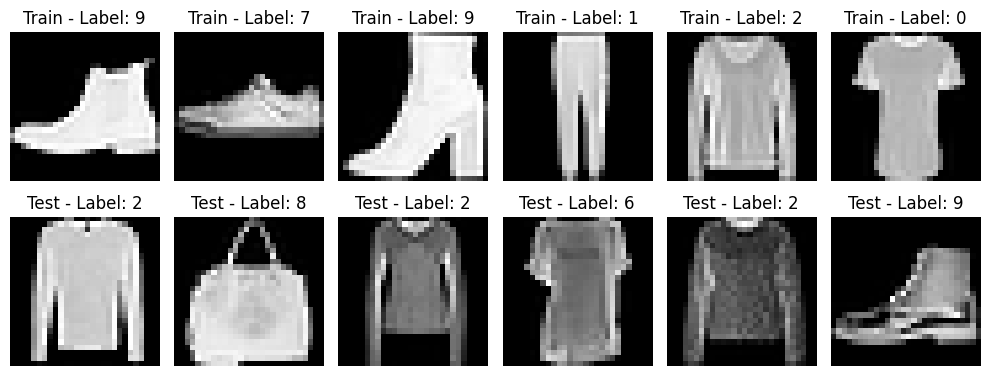

In [3]:
# 选择要显示的图片数量
num_images = 6

# 设置图像的行和列
fig, axes = plt.subplots(2, num_images, figsize=(10, 4))

# 随机选择图片的索引
random_indices_train = np.random.choice(len(training_data), num_images, replace=False)
random_indices_test = np.random.choice(len(test_data), num_images, replace=False)

# 遍历每个子图
for i in range(num_images):
    # 获取训练集中的图片和标签
    img_train, label_train = training_data[random_indices_train[i]]
    # 获取测试集中的图片和标签
    img_test, label_test = test_data[random_indices_test[i]]

    # 显示训练集中的图片
    axes[0, i].imshow(img_train.squeeze(), cmap='gray')
    axes[0, i].set_title(f"Train - Label: {label_train}")
    axes[0, i].axis('off')

    # 显示测试集中的图片
    axes[1, i].imshow(img_test.squeeze(), cmap='gray')
    axes[1, i].set_title(f"Test - Label: {label_test}")
    axes[1, i].axis('off')

# 调整子图间距
plt.tight_layout()
# 显示图像
plt.show()

### 4. 创建模型

In [ ]:
class BasicSequentialClassifier(nn.Module):
    def __init__(self, name_list:list=None, layers_dim:list=None, dtype:torch.dtype|None=None, device:str="cpu") -> None:
        super(BasicSequentialClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.ModuleDict()

        for i in range(len(layers_dim)-1):
            name = name_list[i] if name_list else "input" if i == 0 else "output" if i==len(layers_dim)-2 else f"hidden_{i}"
            self.layers.add_module(name, nn.Linear(layers_dim[i], layers_dim[i+1], device=device))
            if i != len(layers_dim)-2:
                self.layers.add_module(f"bn_{i}", nn.BatchNorm1d(layers_dim[i+1], device=device))
                self.layers.add_module(f"ReLU_{i}", nn.ReLU())

    def forward(self, x):
        x = self.flatten(x)
        for layer in self.layers.values():
            x = layer(x)
        return x

class BasicConvolutionClassifier(nn.Module):
    def __init__(self, name_list:list=None, layers_dim:list=None, dtype:torch.dtype|None=None, device:str="cpu") -> None:
        super(BasicConvolutionClassifier, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Conv2d(1, 128,3,padding=1))
        self.layers.append(nn.BatchNorm2d(128))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool2d(kernel_size=2, stride=2)) # 512*14*14

        self.layers.append(nn.Conv2d(128, 128,3,padding=1))
        self.layers.append(nn.BatchNorm2d(128))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool2d(kernel_size=2, stride=2)) # 512*7*7

        self.layers.append(nn.Conv2d(128, 512,3,padding=1))
        self.layers.append(nn.BatchNorm2d(512))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool2d(kernel_size=7, stride=1)) # 512*1*1

        self.layers.append(nn.Flatten())
        self.layers.append(nn.Linear(512,512))
        self.layers.append(nn.BatchNorm1d(512))
        self.layers.append(nn.ReLU())

        self.layers.append(nn.Linear(512,10))
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
        

model_config = dict(layers_dim = [10,11,12,13,10], dtype=torch.bfloat16, device="cuda")
model = BasicSequentialClassifier(**model_config)
# print(model)

model = BasicConvolutionClassifier()
print(model)

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer, batch_size, device="cpu"):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.to(device)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader:DataLoader, model, loss_fn, device="cpu"):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.to(device)
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
batch_size = 60
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

model_config = dict(layers_dim = [28*28,2048,4096,4096,2048,1024,10], dtype=torch.bfloat16, device="cuda")
model = BasicSequentialClassifier(**model_config)
# model = BasicConvolutionClassifier(**model_config)

train_config = dict(dataloader = train_dataloader,
                    model = model,
                    loss_fn = torch.nn.CrossEntropyLoss(),
                    optimizer = torch.optim.Adam(model.parameters()),
                    batch_size = batch_size,
                    device = model_config["device"])
test_config  = dict(dataloader = test_dataloader,
                    model = model,
                    loss_fn = torch.nn.CrossEntropyLoss(),
                    device = model_config["device"])

epochs = 30
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(**train_config)
    test_loop(**test_config)
print("Done!")
